# Qualitative analysis
by: Kaike Wesley Reis

## Modules

In [1]:
# Standard
import plotly.express as px
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns

# Models
import joblib
from sklearn.ensemble import RandomForestClassifier

# Quantitative analysis
from sklearn.metrics import brier_score_loss

# Qualitative analysis
import shap
import umap
from sklearn.manifold import TSNE
from prince import PCA
from scipy import linalg
from matplotlib.patches import Ellipse
from sklearn.utils import resample

In [2]:
# SHAP version to avoid  bugs
shap.__version__

'0.34.0'

# Imports

In [3]:
# Model
model_ml = joblib.load('results_modelsDevelopment/rfc_oversampled.sav')

In [4]:
# Trainset (SMOTE)
x_train = pd.read_csv('results_modelsDevelopment/x_train_SMOTE.csv')
y_train = pd.read_csv('results_modelsDevelopment/y_train_SMOTE.csv')

In [5]:
# Testset
x_test = pd.read_csv('results_modelsDevelopment/x_test.csv')
y_test = pd.read_csv('results_modelsDevelopment/y_test.csv')

In [6]:
# Backtests
x_resp = pd.read_csv('results_modelsDevelopment/x_resp.csv')
y_resp = np.zeros((len(x_resp),))

## Creating specific dataframes

In [7]:
# Complete dataframe
X = pd.concat([x_train, x_test])
Y = pd.concat([y_train, y_test])
# Reset index
X.index = range(0, len(X))
Y.index = range(0, len(Y))
# Auxiliar dataset
df_x = X
df_y = Y

# Model info

In [8]:
# Best model parameters
model_ml.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 29,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1206,
 'verbose': 0,
 'warm_start': True}

In [9]:
# How many samples in backtest was predicted correct for the best model
y_pred_resp = model_ml.predict(x_resp)

# Show result
print('From',len(y_resp),'samples,',sum(y_pred_resp == y_resp),'was correct.')

From 26 samples, 24 was correct.


In [10]:
# Brier score metric
brier_score = brier_score_loss(y_test, model_ml.predict_proba(x_test)[:,1], pos_label=1)
brier_score.round(3)

0.073

## Set plot parameters

In [11]:
import matplotlib as mpl
FONTSIZE = 18

mpl.rcParams['font.family'] = 'Arial'
plt.rc('font',family='Arial', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE + 7, labelsize=FONTSIZE)
plt.rc('xtick', labelsize=FONTSIZE)
plt.rc('ytick', labelsize=FONTSIZE)
plt.rc('legend', fontsize=FONTSIZE)

# Qualitative 1 - Feature Importance (only Ensemble/LR models)

In [12]:
df_featImp = pd.DataFrame(columns=['Feature', 'Importance'])
df_featImp['Feature'] = x_train.columns
df_featImp['Importance'] = model_ml.feature_importances_
df_featImp.sort_values('Importance', ascending=False, inplace=True)

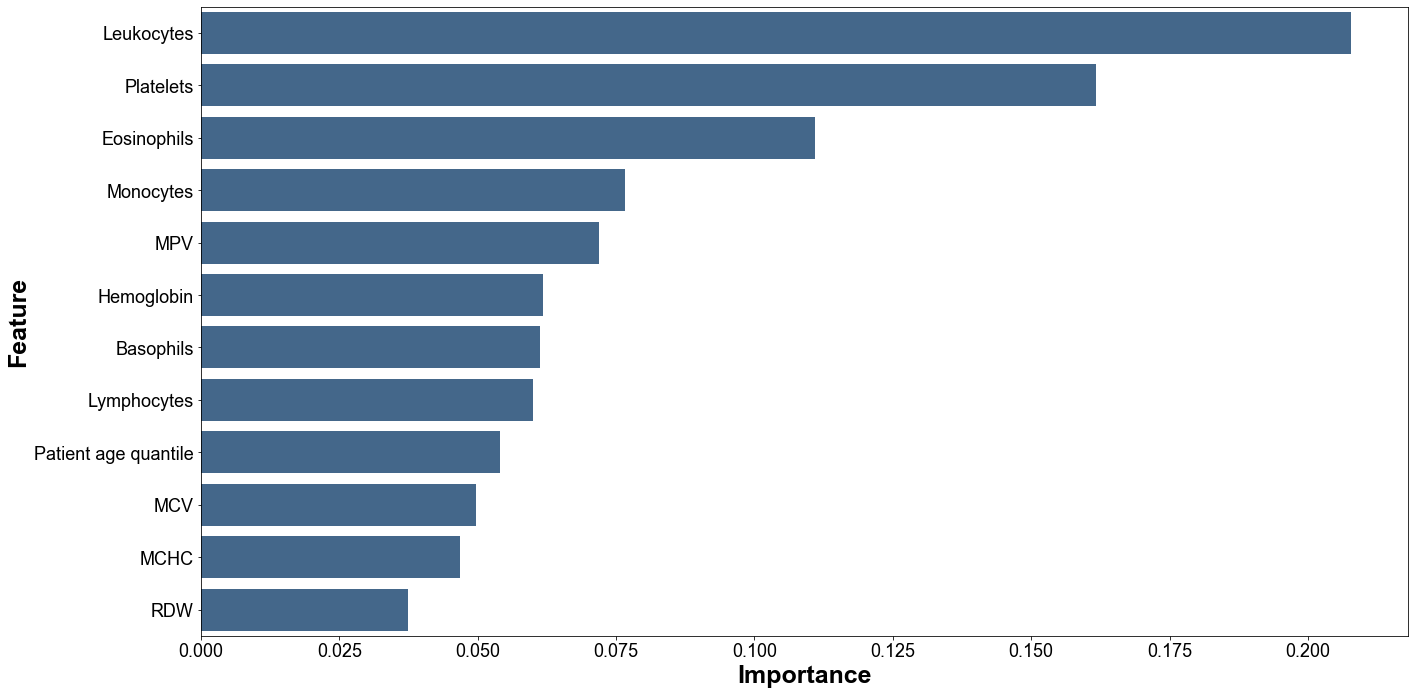

In [13]:
# Plot
fig = plt.figure(figsize=(20,10))
sns.barplot(x="Importance",y='Feature', data=df_featImp, color='#386796')
plt.xlabel('Importance',fontsize=25,fontweight='bold')
plt.ylabel('Feature',fontsize=25,fontweight='bold')
plt.tight_layout()
plt.show()
fig.savefig('results_paperPlots/feature_importance.png', bbox_inches='tight')
plt.close();

# Qualitative 2 - Scatter Plots for relevant features

## Plots - Feature VS COVID-19 Presence

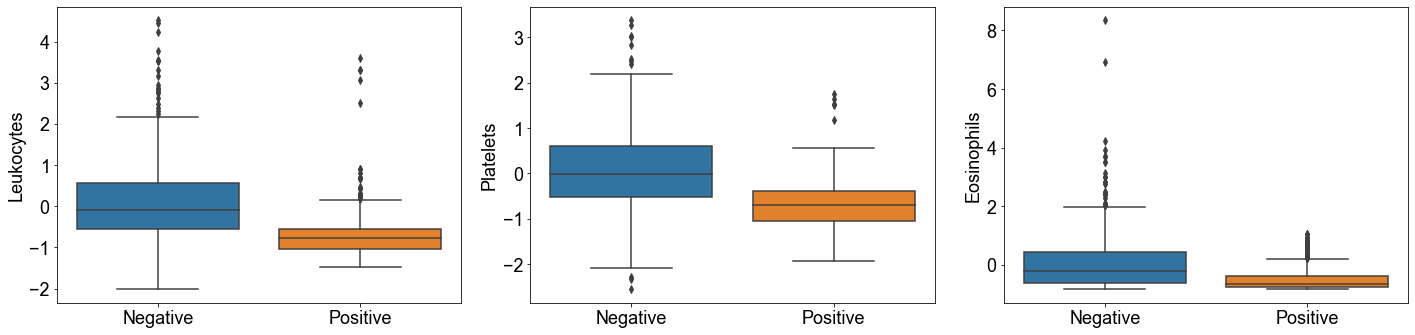

In [14]:
#mpl.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
sns.boxplot(x=y_train['COVID-19 Exam result'], y=x_train['Leukocytes'], ax=ax[0])
sns.boxplot(x=y_train['COVID-19 Exam result'], y=x_train['Platelets'], ax=ax[1])
sns.boxplot(x=y_train['COVID-19 Exam result'], y=x_train['Eosinophils'], ax=ax[2])
ax[0].set_xlabel('');
ax[1].set_xlabel('');
ax[2].set_xlabel('');
ax[0].set_xticklabels(['Negative','Positive']);
ax[1].set_xticklabels(['Negative','Positive']);
ax[2].set_xticklabels(['Negative','Positive']);
plt.tight_layout()
plt.show()
fig.savefig('results_paperPlots/boxplot_imp_features.png', bbox_inches='tight')
plt.close();

# Qualitative analysis 3 - UMap

## Supervised in COVID

In [15]:
# Train
embedding = umap.UMAP(n_neighbors=15,metric='euclidean', random_state=1206).fit_transform(df_x, y=df_y['COVID-19 Exam result'])

In [16]:
# Getting axis
umap_x = embedding.T[0]
umap_y = embedding.T[1]

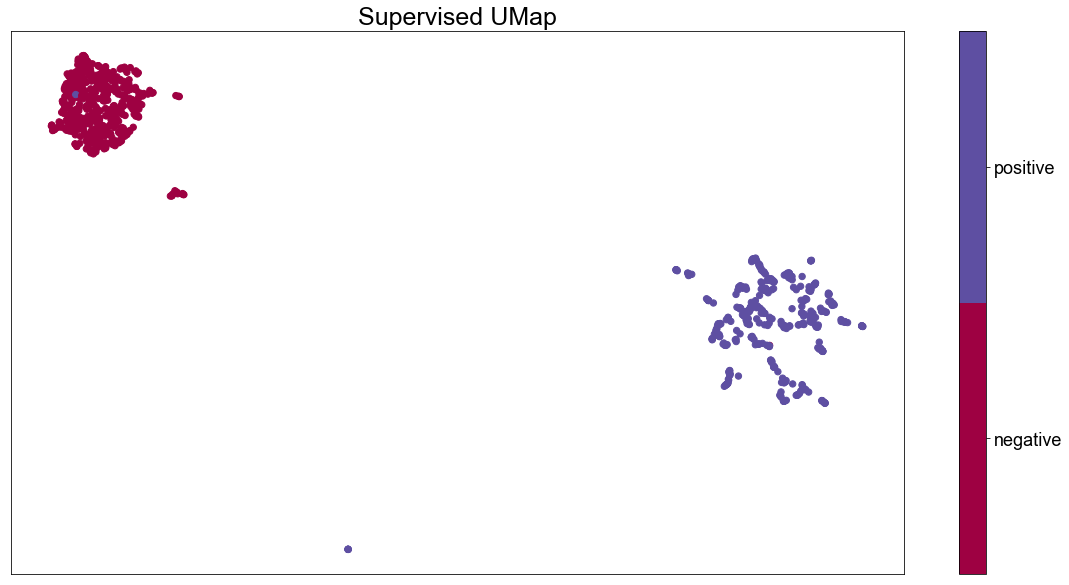

In [17]:
# Plot
fig, ax = plt.subplots(1, figsize=(20, 10))
plt.scatter(*embedding.T,s=40, c=df_y['COVID-19 Exam result'], cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['negative','positive'])
plt.title('Supervised UMap');

Given the lack of interpretability in UMap, this result was not mentioned.

# Qualitative analysis 4 - SHAP

## Prepare SHAP

In [18]:
# Original (margin) result explainer
explainer = shap.TreeExplainer(model=model_ml)

In [19]:
shap_values_train = explainer.shap_values(x_train,y_train)

## Trainset Overall contributions - Dot

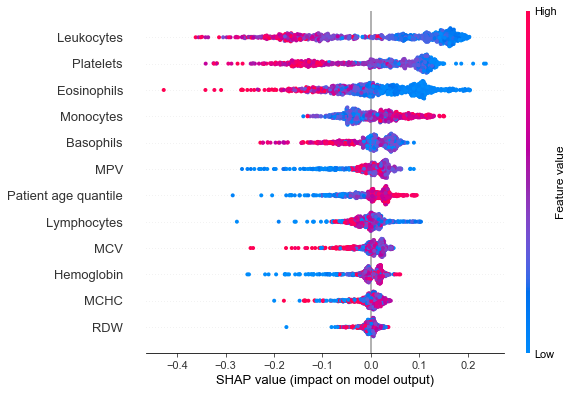

<Figure size 432x288 with 0 Axes>

In [20]:
# summarize the effects of all the features - Class 1
fig = plt.figure(figsize=(20,20))
shap.summary_plot(shap_values_train[1], x_train, plot_type="dot")
plt.tight_layout()
plt.show()
fig.savefig('results_paperPlots/shap_summary.png', bbox_inches='tight')
plt.close();

## Backtest Wrong results with SHAP Analysis

### Get wrong samples by chosen model

In [24]:
# Predict
y_pred_resp = model_ml.predict(x_resp)

In [25]:
# Get indexes where the model got a wrong predict, i.e. said that the pacient got COVID-19
idx_resp = np.where(y_resp != y_pred_resp)[0]

In [26]:
# Samples size
print('From',len(x_resp),'samples',len(idx_resp),'was predicted as False Positive')

From 26 samples 2 was predicted as False Positive


In [27]:
# Get samples
sample_resp = x_resp.loc[idx_resp,:]

In [28]:
# Get baseline value (threshold selection)
expected_value = explainer.expected_value

### SHAP plot - Eval an wrong sample of Any Respiratory Disease

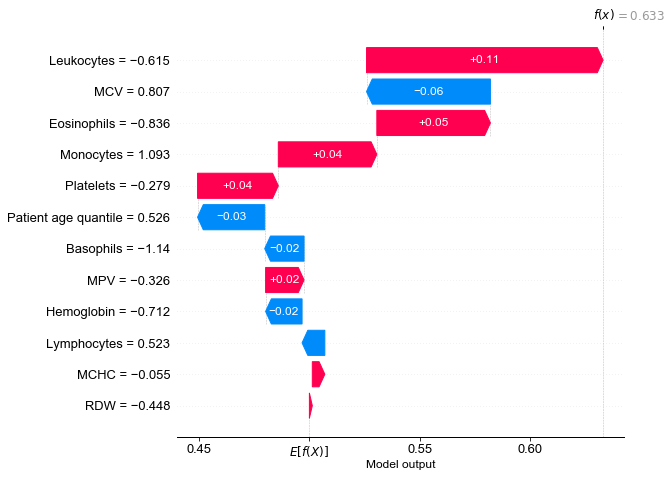

<Figure size 432x288 with 0 Axes>

In [32]:
# Calculate SHAP for that first wrong sample
shap_values = explainer.shap_values(sample_resp.loc[idx_resp[1],:])
# Plot SHAP
fig = plt.figure(figsize=(20,20))
shap.waterfall_plot(expected_value[1], shap_values[1], x_resp.iloc[idx_resp[1],:], max_display=15)
plt.tight_layout()
plt.show()
fig.savefig('results_paperPlots/shap_backtest1.png', bbox_inches='tight')
plt.close();

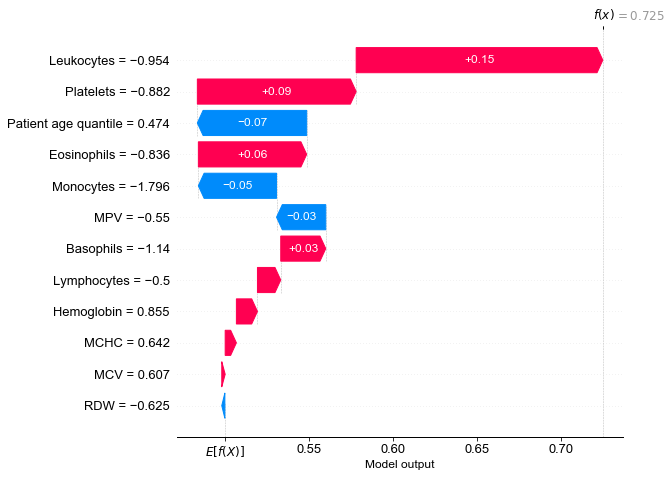

<Figure size 432x288 with 0 Axes>

In [30]:
# Calculate SHAP for that second wrong sample
shap_values = explainer.shap_values(sample_resp.loc[idx_resp[0],:])
# Plot SHAP
fig = plt.figure(figsize=(20,10))
shap.waterfall_plot(expected_value[1],shap_values[1],x_resp.iloc[idx_resp[0],:], max_display=15)
plt.tight_layout()
plt.show()
fig.savefig('results_paperPlots/shap_backtest2.png', bbox_inches='tight')
plt.close();

### SHAP plot - Eval a positive sample classified correctly

In [31]:
# Predict
y_pred = model_ml.predict(x_test)

In [32]:
# Get indexes where the model got a correct positive sample
idx = (y_pred == np.array(y_test['COVID-19 Exam result']))&(np.array(y_test['COVID-19 Exam result'])==1)

In [33]:
# Samples size
print('From',sum(np.array(y_test['COVID-19 Exam result'])==1),'samples',sum(idx),'was predicted correct')

From 12 samples 9 was predicted correct


In [35]:
# Get samples
sample_positive = x_test.loc[idx,:]

In [48]:
# Get a random idx from selected samples
idx_sample = resample(np.array(sample_positive.index), replace=False, n_samples=9, random_state=652)

In [49]:
idx_sample 

array([52,  1, 78, 79, 10,  4, 21, 33, 83], dtype=int64)

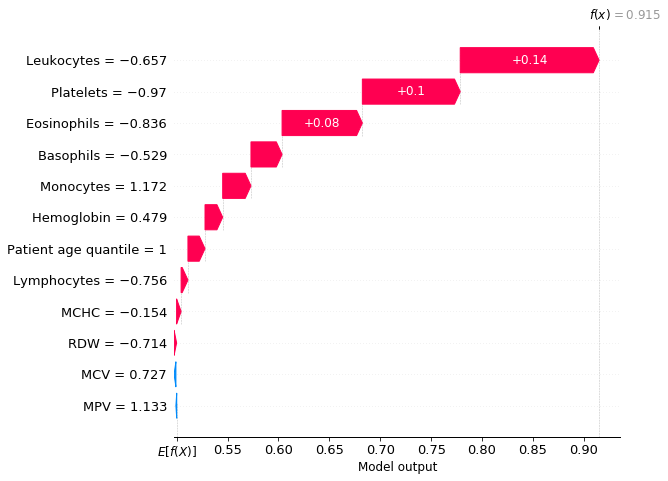

In [59]:
# Define IDX
IDX = idx_sample[0]
# Calculate SHAP for positive sample selected randomly
shap_values = explainer.shap_values(sample_positive.loc[IDX,:])
# Plot SHAP
shap.waterfall_plot(expected_value[1],shap_values[1],sample_positive.loc[IDX,:], max_display=15)